In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (20,13)

# Histogram of Gradients
HOG is a straightforward feature extraction procedure that was developed in the context of identifying pedestrians within images. HOG involves the following steps:

    1. Optionally pre-normalize images. This leads to features that resist dependence on variations in illumination.
    2. Convolve the image with two filters that are sensitive to horizontal and vertical brightness gradients. These capture edge, contour, and texture information.
    3. Subdivide the image into cells of a predetermined size, and compute a histogram of the gradient orientations within each cell.
    4. Normalize the histograms in each cell by comparing to the block of neighboring cells. This further suppresses the effect of illumination across the image.
    5. Construct a one-dimensional feature vector from the information in each cell.

A fast HOG extractor is built into the Scikit-Image project (lol, no need for OpenCV), and we can try it out relatively quickly and visualize the oriented gradients within each cell:

C:\Programzzz\Anaconda_VN\lib\site-packages\skimage\feature\_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


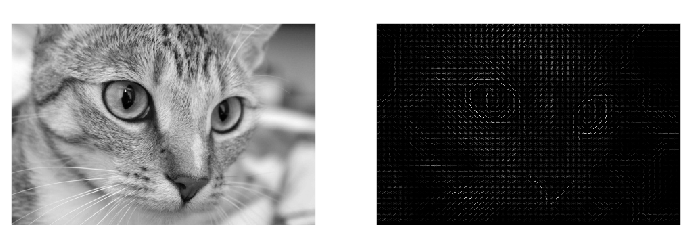

In [46]:
from skimage import data, color, feature, transform
import skimage.data # skimage is "OpenCV" in sklearn package

image = color.rgb2gray(data.chelsea()) # remember that HOG works only with grayscale
hog_vec, hog_vis = feature.hog(image, visualise=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis, cmap='gray')
ax[1].set_title('visualization of HOG features');

# Facial detection algorithm with HOG - steps

Using these HOG features, we can build up a simple facial detection algorithm with any Scikit-Learn estimator; here we will use a linear SVM (support vector machine).

The steps are as follows:

    1. Obtain a set of image thumbnails of faces to constitute "positive" training samples.
    2. Obtain a set of image thumbnails of non-faces to constitute "negative" training samples.
    3. Extract HOG features from these training samples.
    4. Train a linear SVM classifier on these samples.
    5. For an "unknown" image, pass a sliding window across the image, using the model to evaluate whether that window contains a face or not.
    6. If detections overlap, combine them into a single window.

## 1. Obtain a set of positive training samples

In [27]:
# let`s use already known to us dataset with labeled faces - fetch_lfw_people from sklearn.datasets
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
positive_patches = faces.images
positive_patches.shape

(1277, 62, 47)

## 2. Obtain a set of negative training samples
Next we need a set of similarly sized thumbnails which do not have a face in them. One way to do this is to take any corpus of input images, and extract thumbnails from them at a variety of scales. Here we can use some of the images shipped with Scikit-Image, along with Scikit-Learn's PatchExtractor:

In [25]:
# не особо заморачивайся с этим кодом, представь что он просто создаёт np.array
# с 30000 картинок с НЕ лицами

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']

images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]


from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

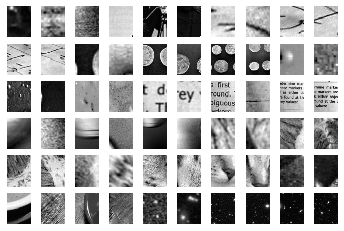

In [26]:
# visualize the negative pictures
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

## 3. Combine datasets and extract HOG features

Now that we have these positive samples and negative samples, we can combine them and compute HOG features. This step takes a little while, because the HOG features involve a nontrivial computation for each image:

In [29]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])

y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

X_train.shape

(31277, 1215)

In total we`ve got 31277 samples in 1215 dimentions. This is the end of the preprocessing part.

## 4. Train an SVM

Next we use the tools we have been exploring in this chapter to create a classifier of thumbnail patches. For such a high-dimensional binary classification task, a Linear support vector machine is a good choice. We will use Scikit-Learn's LinearSVC, because in comparison to SVC it often has better scaling for large number of samples.

First, though, let's use a simple Gaussian naive Bayes to get a quick baseline:

In [37]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# cross_val_score - прогоняет указанные данные в указанном алгоритме и выводит результаты
# кросс-валидации всех проведённых прогонов (мы выбрали cv=5 - пять прогонов)
cross_val_score(GaussianNB(), X_train, y_train, cv=5)

array([0.97762148, 0.99408568, 0.99520384, 0.99648281, 0.9960032 ])

We see that on our training data, even a simple naive Bayes algorithm gets us upwards of 90% accuracy. Let's try the support vector machine, with a grid search over a few choices of the C parameter:

GridSearchCV - Exhaustive search over specified parameter values for an estimator.

In [40]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]}, cv=5)
grid.fit(X_train, y_train)
grid.best_score_

C:\Programzzz\Anaconda_VN\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Programzzz\Anaconda_VN\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Programzzz\Anaconda_VN\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Programzzz\Anaconda_VN\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Programzzz\Anaconda_VN\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

0.9969306519167439

In [42]:
# let`s see what are the best parameters, according to the GridSearchCV
grid.best_params_

{'C': 1.0}

In [45]:
# re-train our SVM model with this parameters
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

## Find faces in the new image

Now that we have this model in place, let's grab a new image and see how the model does. We will use one portion of the astronaut image for simplicity, and run a sliding window over it and evaluate each patch:

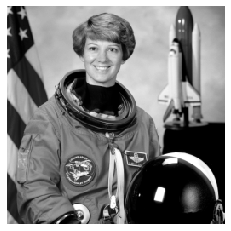

In [64]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5, multichannel=False)


# cropping the image, "uncomment" this line if you want to see how algorithm perfoms
# on the image with a large space taken by face. Leave it "commented" to see how
# algorithm finds a lot of false positives
# test_image = test_image[:160, 40:180] 

plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [65]:
# now we create a window that iterates over patches of this image,
# and compute HOG features for each patch

def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(9409, 1215)

In [66]:
# We take these HOG patches and use our model to evaluate whether each patch contains a face
labels = model.predict(patches_hog)
labels.sum()

# out of 1911 patches we`ve got 24 detections

88.0

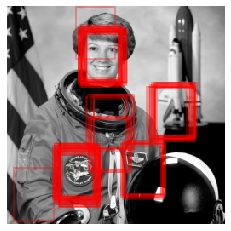

In [67]:
# let`s see where this detections lie

fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

All of the detected patches overlap and found the face in the image! Not bad for a few lines of Python.

# Space for improvment

## Our training set, especially for negative features, is not very complete
Just check all the false-positives on the full scale image.

We might imagine addressing this by adding a wider variety of images to the negative training set, and this would probably yield some improvement. Another way to address this is to use a more directed approach, such as hard negative mining. In hard negative mining, we take a new set of images that our classifier has not seen, find all the patches representing false positives, and explicitly add them as negative instances in the training set before re-training the classifier.

## Our current pipeline searches only at one scale

As currently written, our algorithm will miss faces that are not approximately 62×47 pixels. This can be straightforwardly addressed by using sliding windows of a variety of sizes, and re-sizing each patch using skimage.transform.resize before feeding it into the model. In fact, the sliding_window() utility used here is already built with this in mind.

In OpenCV we can fix this by using the image pyramids

## We should combine overlapped detection patches

For a production-ready pipeline, we would prefer not to have 30 detections of the same face, but to somehow reduce overlapping groups of detections down to a single detection. This could be done via an unsupervised clustering approach (MeanShift Clustering is one good candidate for this), or via a procedural approach such as non-maximum suppression, an algorithm common in machine vision.

## The pipeline should be streamlined

Once we address these issues, it would also be nice to create a more streamlined pipeline for ingesting training images and predicting sliding-window outputs. This is where Python as a data science tool really shines: with a bit of work, we could take our prototype code and package it with a well-designed object-oriented API that give the user the ability to use this easily. 

## More recent advances: use of the Deep Learning

Finally, I should add that HOG and other procedural feature extraction methods for images are no longer state-of-the-art techniques. Instead, many modern object detection pipelines use variants of deep neural networks: one way to think of neural networks is that they are an estimator which determines optimal feature extraction strategies from the data, rather than relying on the intuition of the user. 